# HW6 Clustering
20220041

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

In [14]:
df = pd.read_csv('survey.csv')
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8440 entries, 0 to 8439
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                8440 non-null   int64 
 1   education          8440 non-null   object
 2   education level    8440 non-null   int64 
 3   marital status     8440 non-null   object
 4   Occupation         8440 non-null   object
 5   relationship       8440 non-null   object
 6   race               8440 non-null   object
 7   sex                8440 non-null   object
 8   Investment profit  8440 non-null   int64 
 9   Investment loss    8440 non-null   int64 
 10  hours per week     8440 non-null   int64 
 11  native country     8440 non-null   object
 12  income             8440 non-null   object
dtypes: int64(5), object(8)
memory usage: 857.3+ KB
None
               age  education level  Investment profit  Investment loss  \
count  8440.000000      8440.000000        8440.000000  

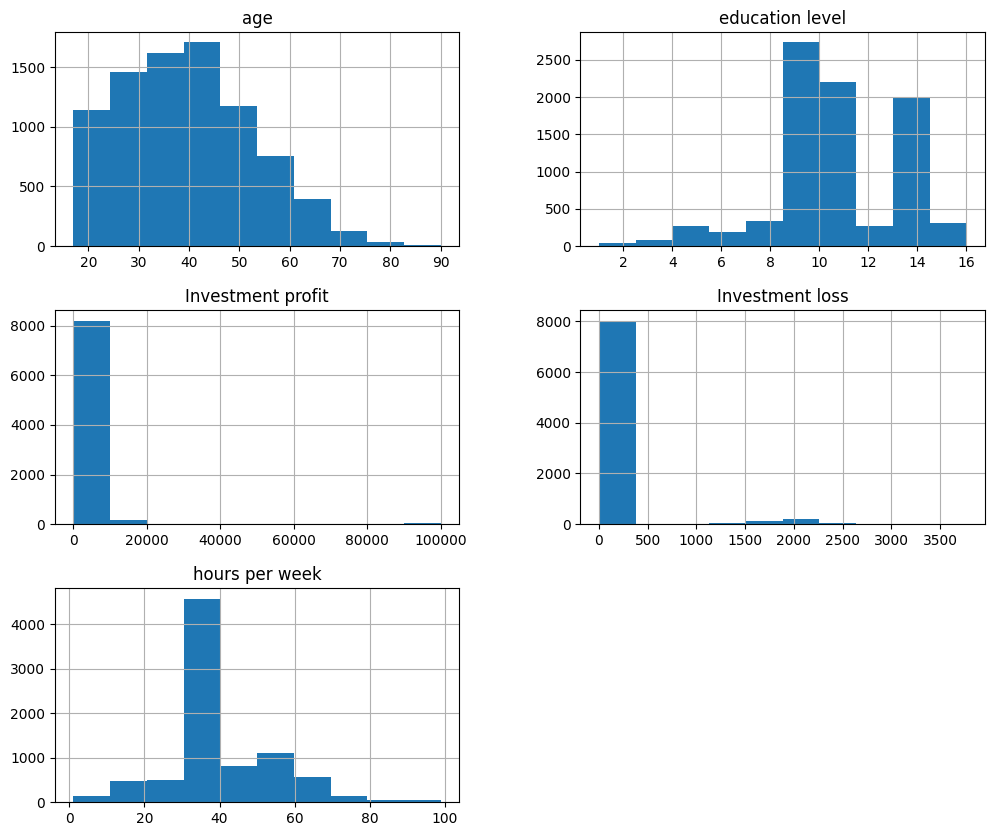

In [15]:
numerical_cols = ['age', 'education level', 'Investment profit', 'Investment loss', 'hours per week']
df[numerical_cols].hist(figsize=(12, 10))
plt.show()

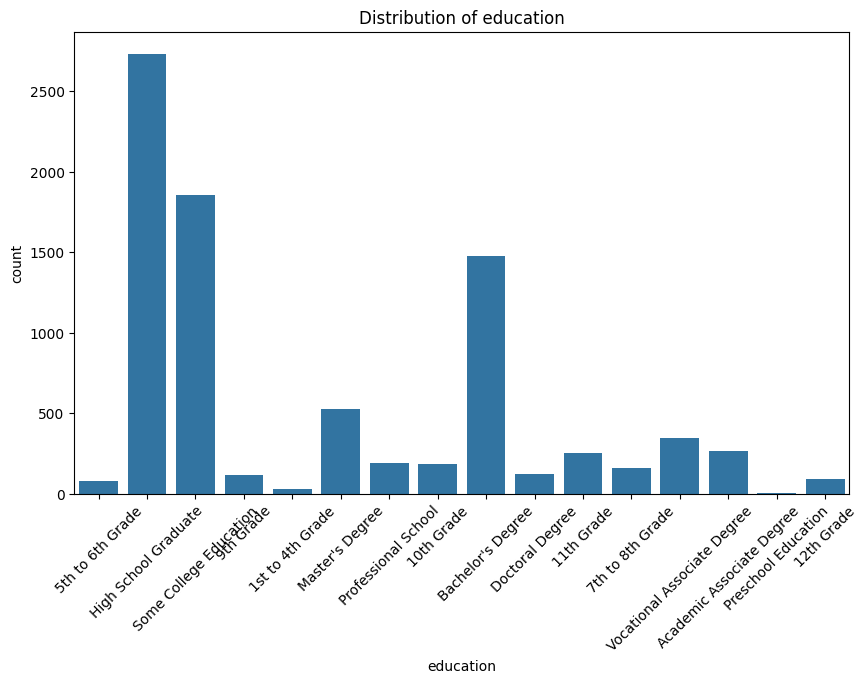

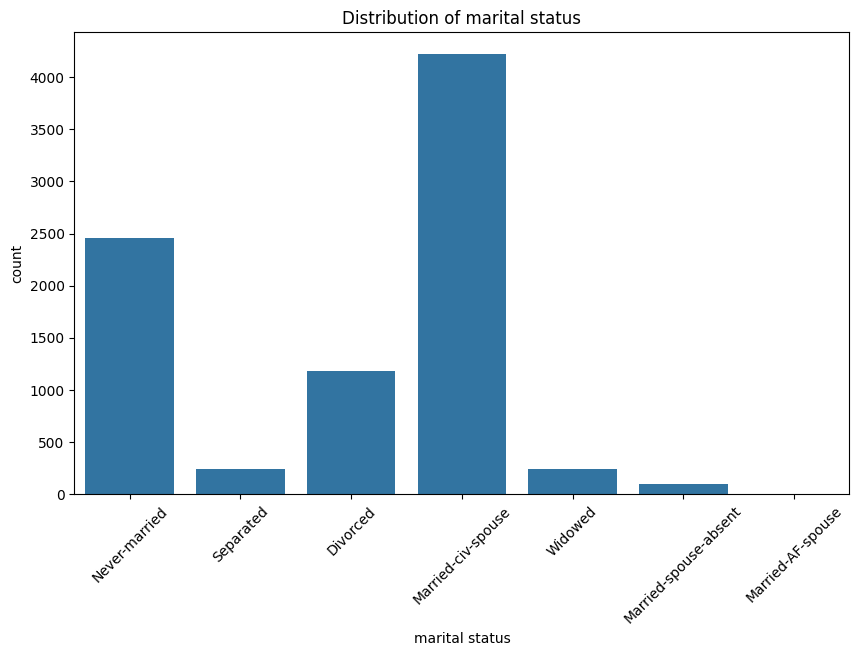

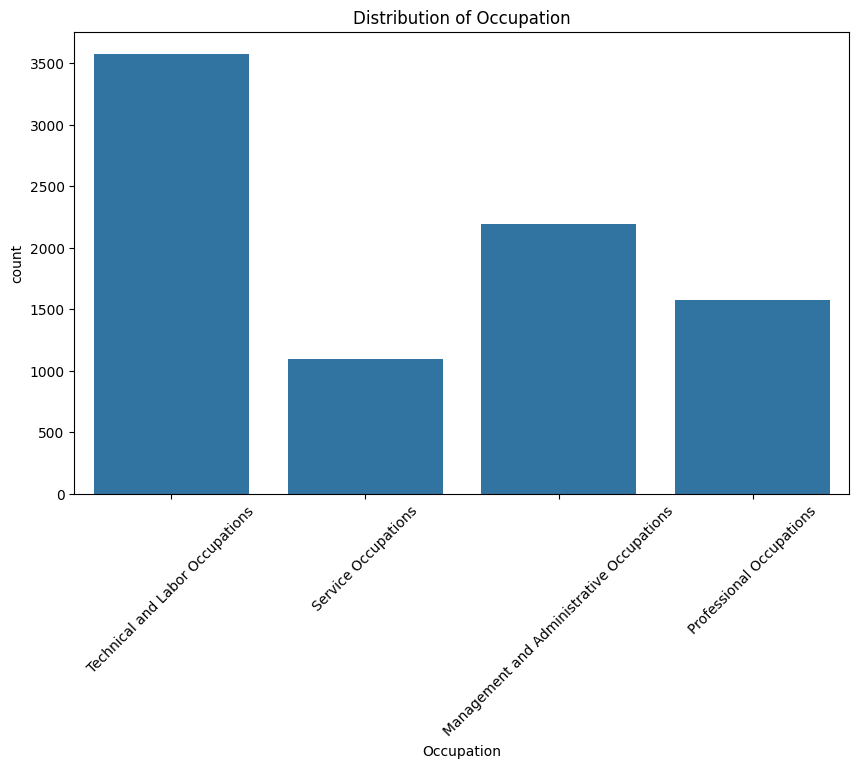

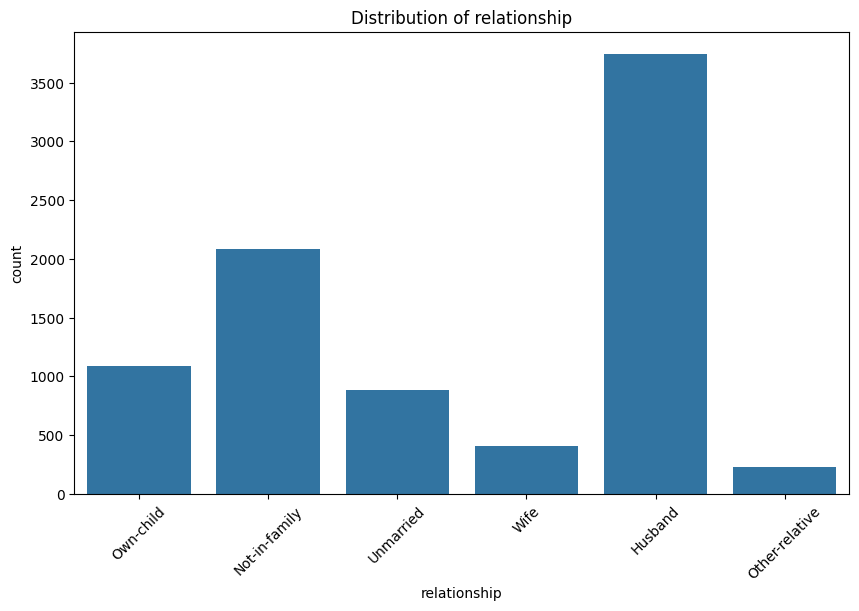

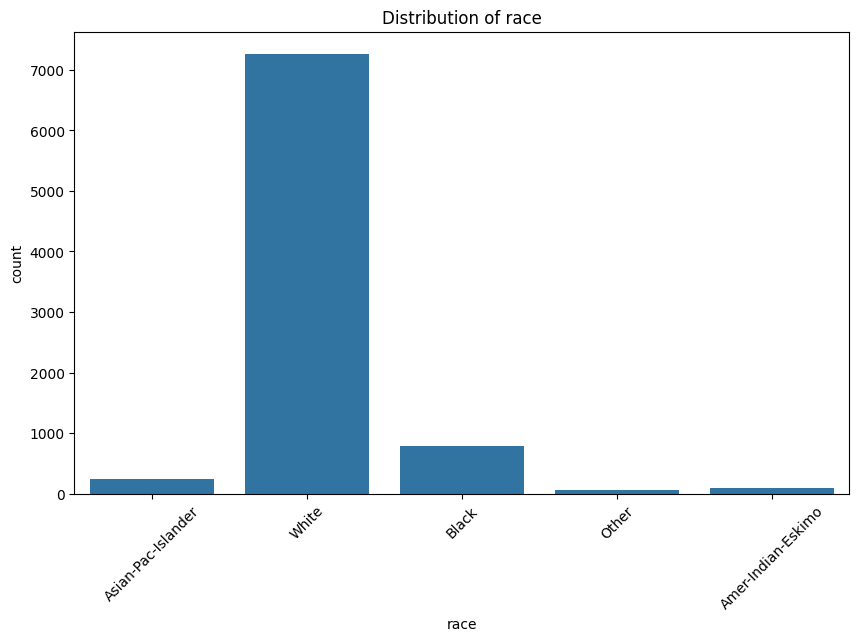

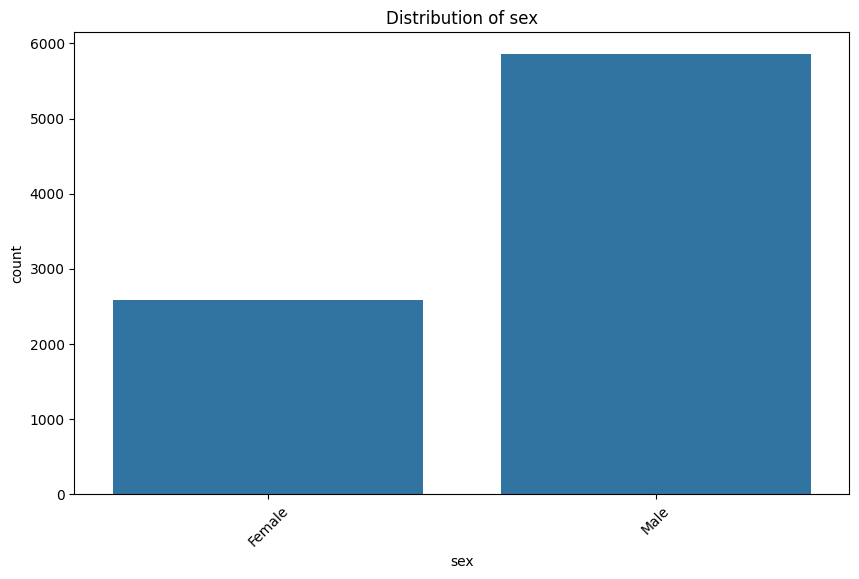

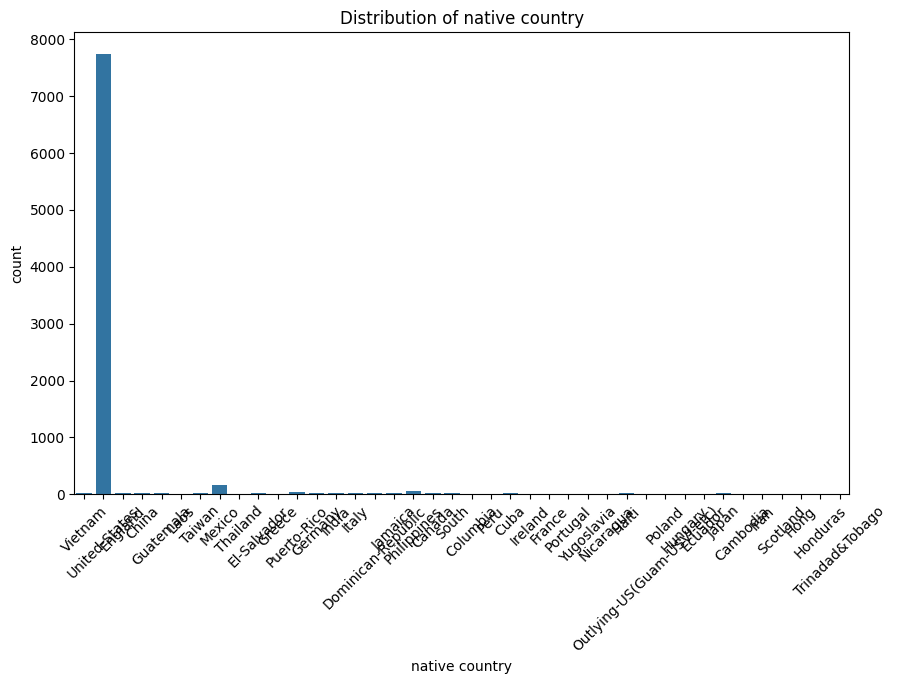

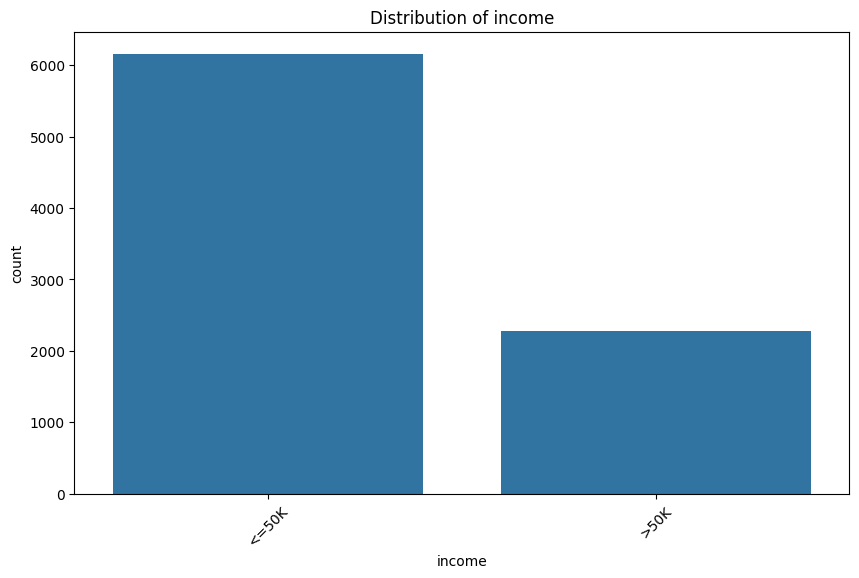

In [16]:
categorical_cols = ['education', 'marital status', 'Occupation', 'relationship', 'race', 'sex', 'native country', 'income']
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()


In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

X = preprocessor.fit_transform(df)
X = X.toarray()

In [18]:
def plot_clusters(data, labels, title):
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=labels, palette='Set2', legend='full')
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster")
    plt.show()

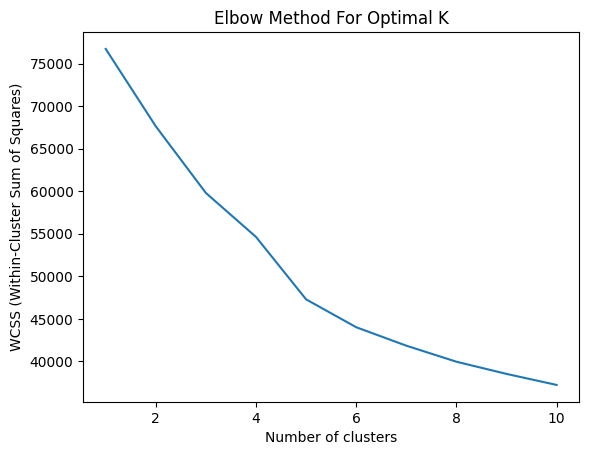

In [19]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

In [20]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
silhouette_kmeans = silhouette_score(X, kmeans_labels)
print(f'Silhouette Score (KMeans): {silhouette_kmeans}')

Silhouette Score (KMeans): 0.14275977643913204


In [ ]:
kmeans_df = pd.DataFrame( {
    'ID': range(len(df)),
    'Employment Type': kmeans_labels
})
kmeans_df.to_csv('km2.csv', index=False)
plot_clusters(X, kmeans_labels, 'kmeans')

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

dbscan_labels = dbscan.fit_predict(X_pca)
dbscan_df = pd.DataFrame({
    'ID': df.index,
    'Employment Type': dbscan_labels
})
dbscan_df.to_csv('dbscan.csv',index=False)
plot_clusters(X, dbscan_labels, 'dbscan')

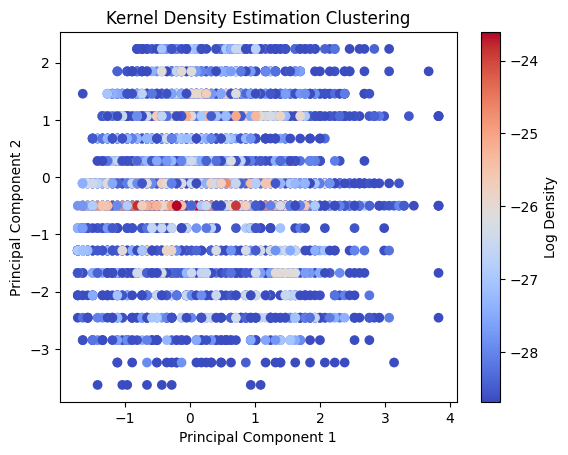

In [22]:
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X)

log_density = kde.score_samples(X)

plt.scatter(X[:, 0], X[:, 1], c=log_density, cmap='coolwarm')
plt.title('Kernel Density Estimation Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Log Density')
plt.show()

Silhouette Score (KDE): 0.04079880324494326



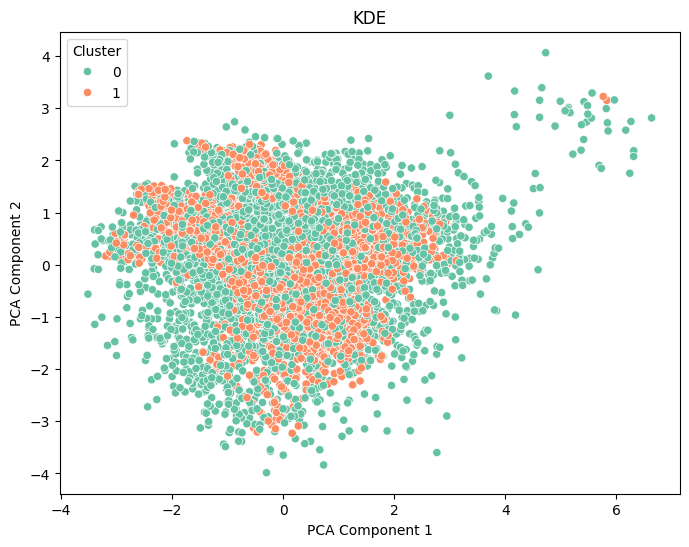

In [23]:
kde_labels = (log_density > np.median(log_density)).astype(int)
silhouette_kde = silhouette_score(X, kde_labels)
print(f'Silhouette Score (KDE): {silhouette_kde}\n')
plot_clusters(X, kde_labels, 'KDE')

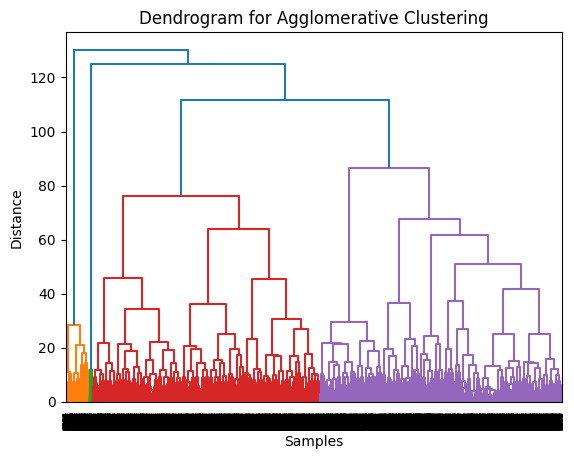

In [24]:
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'), truncate_mode='lastp', p=30)
plt.show()

In [ ]:
sil_scores = []
for n_clusters in range(2, 11):
    agg_clust = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg_clust.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append(score)

plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Score for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
agg = AgglomerativeClustering(n_clusters=4)
agg_labels = agg.fit_predict(X)
agg_df = pd.DataFrame({
    'ID': df.index,
    'Employment Type': agg_labels
})
agg_df.to_csv('agg.csv',index=False)
plot_clusters(X, agg_labels, 'Agglomerative')


In [277]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=400)
print(bandwidth)
mean_shift = MeanShift(bandwidth=bandwidth)
mean_shift_labels = mean_shift.fit_predict(X)
sil_mean_shift = silhouette_score(X, mean_shift_labels)
print(sil_mean_shift)

3.3463349160602833
0.26575895047304865


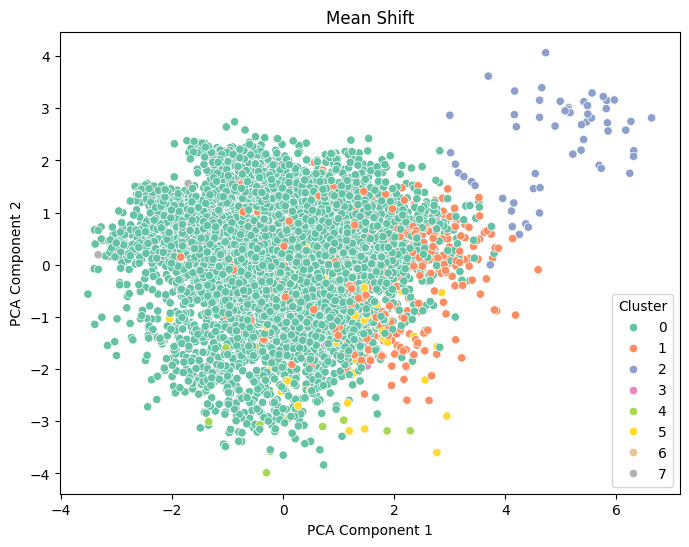

In [ ]:
ms_df = pd.DataFrame({
    'ID': df.index,
    'Employment Type': mean_shift_labels
})
ms_df.to_csv('ms.csv',index=False)
plot_clusters(X, mean_shift_labels, 'Mean Shift')
